# CNN-Transformer Pluggable Fault Detector

This notebook creates a pluggable fault detector using the trained CNN-Transformer model.

**Scenario**: Sequential fault injection with 8h normal, then 17 faults (1h on, 1h off each).

**Evaluation Dataset**: Pre-generated trajectory from notebook 04.

## Configuration & Imports

In [1]:
import os
import json
import time
from pathlib import Path
from dataclasses import dataclass
from typing import List, Tuple, Dict, Any

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, balanced_accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

DATA_DIR = Path('../data')
MODEL_DIR = Path('../outputs/models')
METRICS_DIR = Path('../outputs/metrics')
FIGURES_DIR = Path('../outputs/figures')

METRICS_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

QUICK_MODE = False
if (DATA_DIR / 'detector_trajectory_quick.csv').exists():
    if not (DATA_DIR / 'detector_trajectory.csv').exists():
        QUICK_MODE = True
    else:
        quick_mtime = (DATA_DIR / 'detector_trajectory_quick.csv').stat().st_mtime
        full_mtime = (DATA_DIR / 'detector_trajectory.csv').stat().st_mtime
        QUICK_MODE = quick_mtime > full_mtime

if os.environ.get('QUICK_MODE', '').lower() in ('true', '1', 'yes'):
    QUICK_MODE = True

FILE_SUFFIX = '_quick' if QUICK_MODE else ''

print('='*60)
print('CNN-Transformer Pluggable Fault Detector')
if QUICK_MODE:
    print('QUICK MODE - Using short trajectory')
print(f'Device: {device}')
print('='*60)

CNN-Transformer Pluggable Fault Detector
Device: cuda


## Define Model Architecture

In [2]:
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=100):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))
        
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class CNNTransformer(nn.Module):
    """CNN-Transformer: CNN feature extraction + Transformer attention.
    
    Matches 23-cnn-transformer-final-training.ipynb.
    """
    def __init__(self, input_size, conv_filters, kernel_size, d_model, 
                 nhead, num_encoder_layers, dim_feedforward, dropout, num_classes):
        super().__init__()
        
        self.conv1 = nn.Conv1d(input_size, conv_filters, kernel_size, padding='same')
        self.bn1 = nn.BatchNorm1d(conv_filters)
        self.conv2 = nn.Conv1d(conv_filters, d_model, kernel_size, padding='same')
        self.bn2 = nn.BatchNorm1d(d_model)
        
        self.pos_encoder = PositionalEncoding(d_model)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward,
            dropout=dropout, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_encoder_layers)
        
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(d_model, num_classes)
        
    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.relu(self.bn2(self.conv2(x)))
        x = x.permute(0, 2, 1)
        
        x = self.pos_encoder(x)
        x = self.transformer(x)
        x = x.mean(dim=1)
        x = self.dropout(x)
        return self.fc(x)

print('Model class defined')

Model class defined


## Load Trained Model

In [3]:
print('\n[Step 1/5] Loading trained CNN-Transformer model...')

model_path = MODEL_DIR / 'cnn_transformer_final.pt'
model_data = torch.load(model_path, map_location=device, weights_only=False)

config = model_data['model_config']
features = model_data['features']
label_classes = model_data['label_encoder_classes']
scaler_mean = model_data['scaler_mean']
scaler_scale = model_data['scaler_scale']

num_classes = len(label_classes)
class_to_idx = {c: i for i, c in enumerate(label_classes)}
idx_to_class = {i: c for i, c in enumerate(label_classes)}

model = CNNTransformer(
    input_size=len(features),
    conv_filters=config['conv_filters'],
    kernel_size=config['kernel_size'],
    d_model=config['d_model'],
    nhead=config['nhead'],
    num_encoder_layers=config['num_encoder_layers'],
    dim_feedforward=config['dim_feedforward'],
    dropout=config['dropout'],
    num_classes=num_classes
)
model.load_state_dict(model_data['model_state_dict'])
model.to(device)
model.eval()

print(f'Model loaded from {model_path}')
print(f'  Features: {len(features)}')
print(f'  Classes: {num_classes}')


[Step 1/5] Loading trained CNN-Transformer model...
Model loaded from ../outputs/models/cnn_transformer_final.pt
  Features: 52
  Classes: 18


## Create Detector

In [4]:
@dataclass
class DetectionResult:
    fault_class: int
    confidence: float
    step: int
    alternatives: List[Tuple[int, float]]
    statistics: Dict[str, Any]

class SequenceBuffer:
    def __init__(self, seq_len, n_features, scaler_mean, scaler_scale):
        self.seq_len = seq_len
        self.buffer = np.zeros((seq_len, n_features), dtype=np.float32)
        self.scaler_mean = scaler_mean
        self.scaler_scale = scaler_scale
        self.count = 0

    def add(self, features):
        self.buffer = np.roll(self.buffer, -1, axis=0)
        self.buffer[-1] = (features - self.scaler_mean) / self.scaler_scale
        self.count += 1

    def is_ready(self):
        return self.count >= self.seq_len

    def get_sequence(self):
        return self.buffer.copy()

print('Detector classes defined')

Detector classes defined


## Load Trajectory

In [5]:
print('\n[Step 2/5] Loading pre-generated trajectory...')

traj_file = DATA_DIR / f'detector_trajectory{FILE_SUFFIX}.csv'
traj_df = pd.read_csv(traj_file)

info_file = DATA_DIR / f'detector_trajectory{FILE_SUFFIX}_info.json'
with open(info_file) as f:
    traj_info = json.load(f)

FAULT_CLASSES = traj_info['fault_classes']
RECORD_INTERVAL = traj_info['record_interval_seconds']

print(f'Loaded trajectory: {len(traj_df)} samples, {traj_info["total_hours"]} hours')
print(f'Faults: {len(FAULT_CLASSES)}')


[Step 2/5] Loading pre-generated trajectory...


Loaded trajectory: 875 samples, 42 hours
Faults: 17


## Run Detection

In [6]:
print('\n[Step 3/5] Running fault detection...')
detect_start = time.time()

seq_len = config['sequence_length']
xmeas_cols = [f'xmeas_{i}' for i in range(1, 42)]
xmv_cols = [f'xmv_{i}' for i in range(1, 12)]
feature_cols = xmeas_cols + xmv_cols

buffer = SequenceBuffer(seq_len, len(features), scaler_mean, scaler_scale)

detections = []
for idx, row in traj_df.iterrows():
    feat = row[feature_cols].values.astype(np.float32)
    buffer.add(feat)
    
    if buffer.is_ready():
        seq = torch.tensor(buffer.get_sequence()).unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(seq)
            probs = torch.softmax(output, dim=1).cpu().numpy()[0]
        
        pred_idx = probs.argmax()
        pred_class = int(idx_to_class[pred_idx])
        confidence = float(probs.max())
        
        top3 = np.argsort(probs)[::-1][:3]
        alternatives = [(int(idx_to_class[i]), float(probs[i])) for i in top3]
    else:
        pred_class = 0
        confidence = 0.0
        alternatives = []
    
    detections.append({
        'step': int(row['step']),
        'time_hours': row['time_hours'],
        'predicted_class': pred_class,
        'confidence': confidence,
        'true_class': int(row['faultNumber'])
    })

detections_df = pd.DataFrame(detections)
detections_df['correct'] = detections_df['predicted_class'] == detections_df['true_class']

print(f'Detection complete in {time.time() - detect_start:.2f}s')
print(f'  Samples: {len(detections_df)}')
print(f'  Accuracy: {detections_df["correct"].mean():.4f}')


[Step 3/5] Running fault detection...


Detection complete in 1.19s
  Samples: 875
  Accuracy: 0.4160


## Compute Metrics

In [7]:
print('\n[Step 4/5] Computing metrics...')

y_true = detections_df['true_class'].values
y_pred = detections_df['predicted_class'].values

overall_accuracy = accuracy_score(y_true, y_pred)
balanced_acc = balanced_accuracy_score(y_true, y_pred)
f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)
f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)

y_true_binary = (y_true != 0).astype(int)
y_pred_binary = (y_pred != 0).astype(int)
fault_det_acc = accuracy_score(y_true_binary, y_pred_binary)
fault_det_recall = recall_score(y_true_binary, y_pred_binary, zero_division=0)

print('\nOverall Performance:')
print('='*50)
print(f'Multiclass Accuracy: {overall_accuracy:.4f}')
print(f'Balanced Accuracy: {balanced_acc:.4f}')
print(f'F1 (weighted): {f1_weighted:.4f}')
print(f'F1 (macro): {f1_macro:.4f}')
print(f'Fault Detection Recall: {fault_det_recall:.4f}')
print('='*50)


[Step 4/5] Computing metrics...

Overall Performance:
Multiclass Accuracy: 0.4160
Balanced Accuracy: 0.2675
F1 (weighted): 0.4368
F1 (macro): 0.1896
Fault Detection Recall: 0.7619


## Visualizations

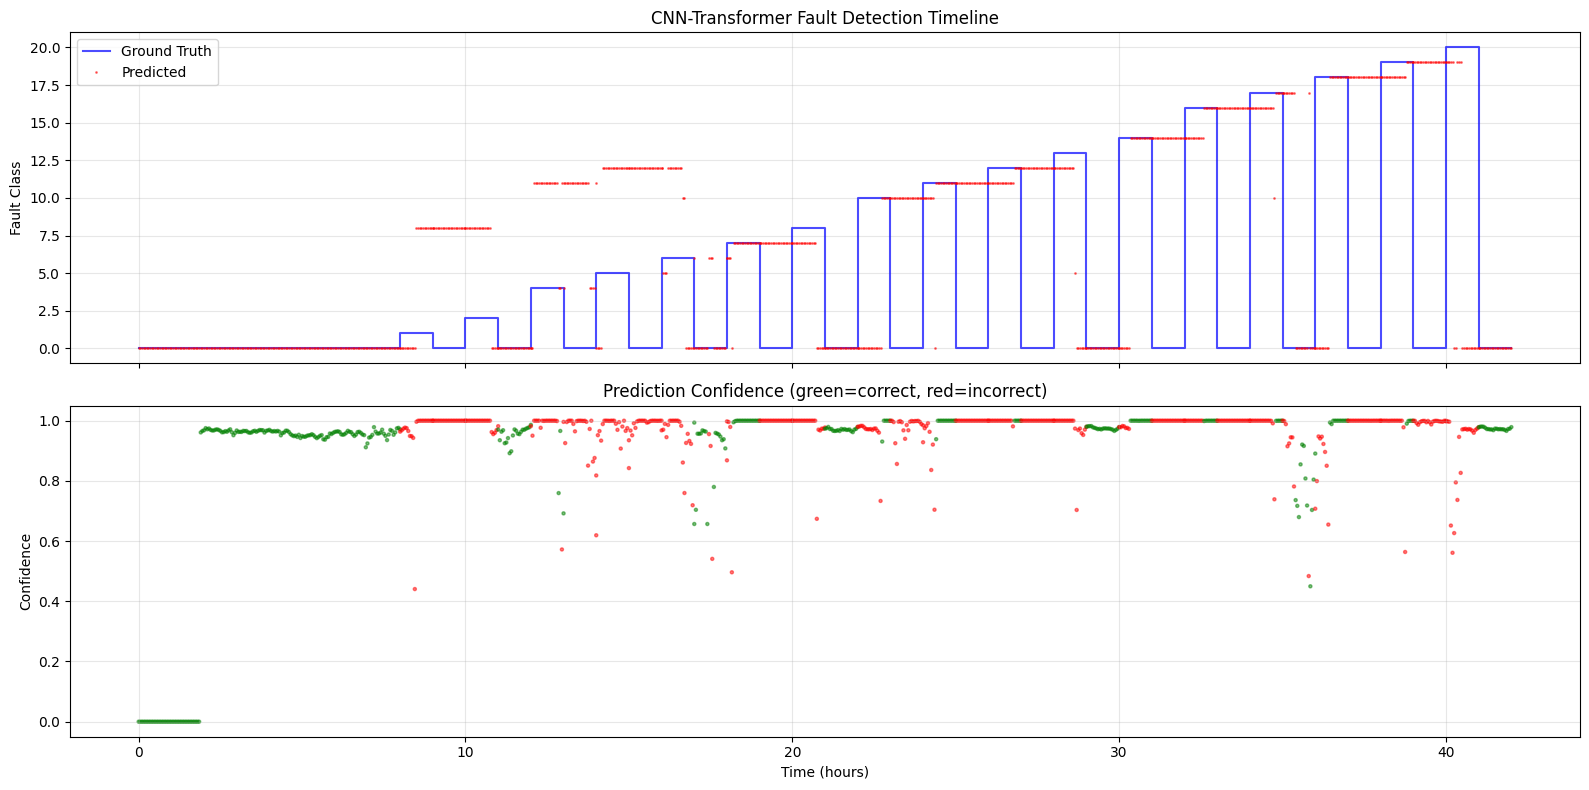

Saved to ../outputs/figures/cnn_transformer_detector_timeline.png


In [8]:
fig, axes = plt.subplots(2, 1, figsize=(16, 8), sharex=True)

time_h = detections_df['time_hours'].values

ax = axes[0]
ax.plot(time_h, detections_df['true_class'], 'b-', linewidth=1.5, label='Ground Truth', alpha=0.7)
ax.plot(time_h, detections_df['predicted_class'], 'r.', markersize=2, label='Predicted', alpha=0.5)
ax.set_ylabel('Fault Class')
ax.set_title('CNN-Transformer Fault Detection Timeline')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1]
colors = ['green' if c else 'red' for c in detections_df['correct']]
ax.scatter(time_h, detections_df['confidence'], c=colors, s=5, alpha=0.5)
ax.set_ylabel('Confidence')
ax.set_xlabel('Time (hours)')
ax.set_title('Prediction Confidence (green=correct, red=incorrect)')
ax.grid(True, alpha=0.3)

plt.tight_layout()
output_file = FIGURES_DIR / f'cnn_transformer_detector_timeline{FILE_SUFFIX}.png'
plt.savefig(output_file, dpi=150, bbox_inches='tight')
plt.show()
print(f'Saved to {output_file}')

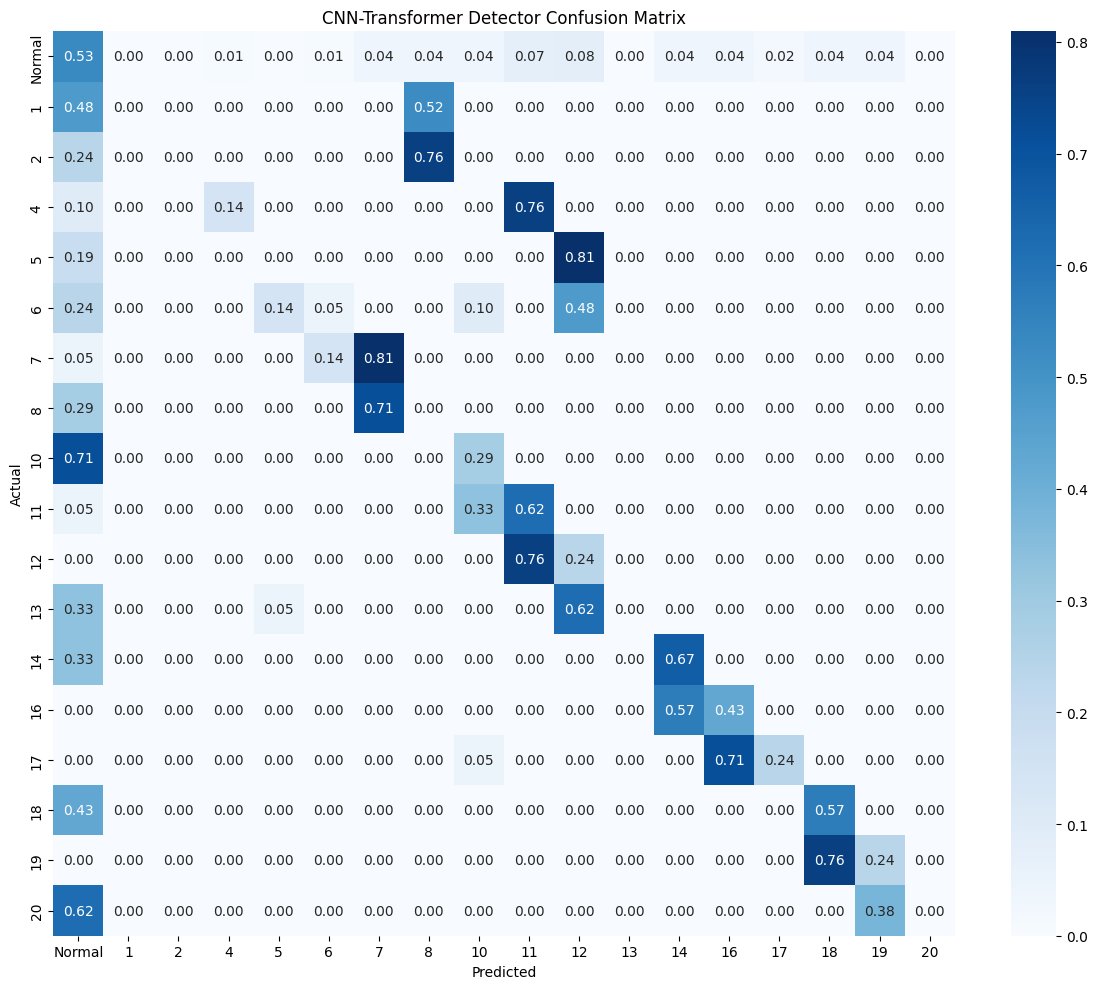

Saved to ../outputs/figures/cnn_transformer_detector_confusion_matrix.png


In [9]:
all_classes = sorted(set(y_true) | set(y_pred))
class_labels = ['Normal' if c == 0 else str(int(c)) for c in all_classes]

cm = confusion_matrix(y_true, y_pred, labels=all_classes)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('CNN-Transformer Detector Confusion Matrix')

plt.tight_layout()
output_file = FIGURES_DIR / f'cnn_transformer_detector_confusion_matrix{FILE_SUFFIX}.png'
plt.savefig(output_file, dpi=150, bbox_inches='tight')
plt.show()
print(f'Saved to {output_file}')

## Save Results

In [10]:
print('\n[Step 5/5] Saving results...')

results = {
    'model': 'CNN-Transformer',
    'detector_type': 'pluggable',
    'quick_mode': QUICK_MODE,
    'simulation': {
        'total_hours': traj_info['total_hours'],
        'total_samples': len(detections_df),
        'faults_tested': FAULT_CLASSES
    },
    'overall_metrics': {
        'accuracy': float(overall_accuracy),
        'balanced_accuracy': float(balanced_acc),
        'f1_weighted': float(f1_weighted),
        'f1_macro': float(f1_macro),
        'fault_detection_recall': float(fault_det_recall)
    }
}

output_file = METRICS_DIR / f'cnn_transformer_detector_results{FILE_SUFFIX}.json'
with open(output_file, 'w') as f:
    json.dump(results, f, indent=2)
print(f'Saved to {output_file}')


[Step 5/5] Saving results...
Saved to ../outputs/metrics/cnn_transformer_detector_results.json


In [11]:
print('\n' + '='*60)
print('CNN-Transformer Pluggable Detector Complete!')
if QUICK_MODE:
    print('(Quick mode)')
print('='*60)
print(f'\nAccuracy: {overall_accuracy:.4f}')
print(f'F1 (weighted): {f1_weighted:.4f}')
print(f'Fault Detection Recall: {fault_det_recall:.4f}')
print('='*60)


CNN-Transformer Pluggable Detector Complete!

Accuracy: 0.4160
F1 (weighted): 0.4368
Fault Detection Recall: 0.7619
